# Introduzione

In questo esercizio ci occuperemo di studiare le proprietà di equilibrio del gas nobile Argon attraverso il Molecular Dynamics (MD). In particolare, [si identifica in generale con il termine MD quell'insieme di tecniche computazionali di simulazione che, mediante l'integrazione delle equazioni del moto, permette di studiare la dinamica di evoluzione di un sistema fisico e chimico a livello atomico e molecolare](https://it.wikipedia.org/wiki/Dinamica_molecolare).

Vogliamo studiare quali siano l'energia totale interna per particella, $E/N$, l'energia potenziale di legame per particella, $U/N$, l'energia cinetica per particella $K/N$ ed infine la temperatura del sistema, $T$, nelle tre diverse fasi che presenta in natura. 

Prima di procedere abbiamo però integrato il codice che lei ci ha fornito per adattarlo ai nostri scopi. Tre sono le modifiche apportate.

#### 1. Configurazione precedente
La prima è l'introduzione della possibilità di **partire dalla configurazione finale di un esperimento precedente desiderata** piuttosto che da una configurazione cristallina. In particolare, abbiamo considerato una diversa configurazione per ogni fase del sistema altrimenti questa miglioria sarebbe risultata particolarmente inutile. Quello che ci aspettiamo è chiaramente che la modifica introdotta faciliti la convergenza del sistema allo stato di equilibrio. 


#### 2. Riscalamento della velocità
La seconda modifica mira sempre a facilitare la convergenza del sistema allo stato di equilibrio. Essa consiste nell'implementazione di un sistema di **correzione per la configurazione iniziale** affinché sia più simile alla configurazione di equilibrio. Per fare questo abbiamo semplicemente aggiunto nel main una funzione `Equilibration()` in cui si eseguono `equilibration_time` passi con riscalamento della velocità:

        int main(int argc, char ** argv){ 
            Input(argc, argv);             //Inizialization
            Equilibration();			//Equilibration
              ...
        return 0;
        }
        
  
dove:

    
        void Equilibration (void){
            ...
            for (int i=0; i<=equilibration_time; i++) {
                Move();	}
            equilibration_time=0;
        };
        
    
    
Vediamo ora nel dettaglio come abbiamo eseguito il riscalamento della velocità per ogni passo nella funzione `Move()`:

1. Generiamo la configurazione $\vec r(t+dt)$ attraverso l'algoritmo di Verlet. 
2. Ne stimiamo la temperatura a partire dall'energia cinetica per particella: $ T_{stimata}= \frac{2}{3}e_{kin}$
3. Correggiamo la velocità delle singole particelle affinché corrisponda maggiormente con la temperatura a cui vogliamo che il sistema si trovi. Per farlo sfruttiamo il teorema di equipartizione: 
$$\frac{1}{2}m v^2_x = \frac{1}{2} k_B T \quad \implies \quad v^{attesa}_{x,y,z}= \sqrt{\frac{T_{attesa}}{T_{stimata}}}v_{x,y,z}^{stimata}$$
4. A partira dalla nuova velocità generiamo una configurazione che sia più simile a quella di equilibrio. 
5. Ripetiamo questi passaggi un numero di volte pari al tempo di equilibrazione. 

        
        void Move(void){ 
            ...

            if((rescale_position == 1) & (equilibration_time !=0)){
                    double t = 0;
                    double correction_factor;

                    for (int i=0; i<npart; ++i) t += 0.5 * (vx[i]*vx[i] + vy[i]*vy[i] + vz[i]*vz[i]);
                    stima_temp = (2.0 / 3.0) * t/(double)npart; //Temperature
                    correction_factor = temp/stima_temp;
                    for (int i=0; i<npart; ++i){
                        vx[i]=pow(correction_factor,0.5)*vx[i];
                        vy[i]=pow(correction_factor,0.5)*vy[i];
                        vz[i]=pow(correction_factor,0.5)*vz[i];
                        xold[i] = Pbc(x[i] - vx[i] * delta);
                        yold[i] = Pbc(y[i] - vy[i] * delta);
                        zold[i] = Pbc(z[i] - vz[i] * delta);
                    }
            }

            ...
            }
    
        
#### 3. Media a blocchi
La terza è l'aggiunta di un meccanismo di **media a blocchi**.


In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
import string
from scipy.optimize import curve_fit
import scipy
from scipy.special import erf
from scipy import log, exp, sqrt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stat
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import subprocess as sb
from os import system
import os
import shutil

sns.set_theme(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1.2, color_codes=True, rc=None)

In [2]:
# Physical constants in SI units (arbitrarily approximated...)
boltzmann_constant = 1.381e-23
atomic_mass_unit = 1.661e-27

# Utilities
L_block = 20
integration_step = 0.0005

# Unit scales
length = 0.34e-9                 
energy = 120 * boltzmann_constant
mass = 39.948 * atomic_mass_unit

time = np.sqrt(mass * length**2 / energy)
temp = energy/boltzmann_constant

In [3]:
phases = ['solid', 'liquid', 'gas','dat']
out = ['temp','ekin','etot','epot','pres','gave','gofr']
SI_unit=[temp,energy,energy,energy]
unit = ['  [K]','  [J]','  [J]','  [J]']
T=[0.8,1.1,1.2]
path = os.path.abspath(os.getcwd())+'/Exercises_04.1/'


os.chdir(path)

## Verifica modifiche

Consideriamo l'argon in tre diverse fasi. Mostriamo che se utilizziamo la prima e la seconda modifica, allora riusciamo a far convergere il sistema alla temperatura desiderata. Senza queste due correzioni il sistema impiegherebbe troppo tempo. In particolare calcoliamo il tempo di equilibrazione, ossia il numero di passi necessari per portare il sistema alla temperatura $T$ eseguendo ad ogni passo un risclamento della velocità (*modifica 2*). Chiaramente esso dipende dalla configurazione iniziale per la nostra simulazione e pertanto distinguiamo due casi: 

* Il caso in cui il sistema evolva da una configurazione cristallina ($T=0$) ad una temperatura $T$. 

* Il caso in cui il sistema evolva da una vecchia configurazione associata alla fase dell'argon che prendiamo in considerazione (*modifica 1*). 

Valutiamo poi quale sia la temperatura del sistema una volta terminata l'equilibrazione e la confrontiamo con quella del sistema nel caso in cui sia lasciato libero di muoversi.

In [4]:
# 0.  temp; 1. npart; 2. rho; 3. rcut; 4. delta; 5. nblk; 6. nstep_TOT; 7. iprint; 8. rescale_position; 9. start_old; 10. equilibration_time;

for i in range(3):
    # Cambio il numero di step
    a_file = open(path+'input.'+phases[i], "r")
    list_of_lines = a_file.readlines()
    list_of_lines[6] = "5000\n"
    list_of_lines[8] = "0\n"
    list_of_lines[9] = "0\n"
    list_of_lines[10] = "0\n"
    a_file = open(path+'input.'+phases[i], "w")
    a_file.writelines(list_of_lines)
    a_file.close()

    # Compilo il programma con il nuovo file di input
    sb.call('./clean.sh', shell=True)
    os.system('./make')
    os.system('./MolDyn_NVE.exe'+' '+phases[i])

    # Carico i dati da file
    df_appo = pd.DataFrame({'temp': np.loadtxt(path+'output_temp.dat', unpack = True ,delimiter = ","),
                           'epot': np.loadtxt(path+'output_epot.dat', unpack = True ,delimiter = ","),
                           'etot': np.loadtxt(path+'output_etot.dat', unpack = True ,delimiter = ","),
                           'ekin': np.loadtxt(path+'output_ekin.dat', unpack = True ,delimiter = ","),
                            'phases':phases[i]
                            })
    if i ==0:
        df_0 = df_appo
    else:
        df_0 = df_0.append(df_appo)

In [5]:
# 0.  temp; 1. npart; 2. rho; 3. rcut; 4. delta; 5. nblk; 6. nstep_TOT; 7. iprint; 8. rescale_position; 9. start_old; 10. equilibration_time;
equilibration =[110,200,40000]

for i in range(3):
    # Cambio il numero di step
    a_file = open(path+'input.'+phases[i], "r")
    list_of_lines = a_file.readlines()
    list_of_lines[6] = "5000\n"
    list_of_lines[8] = "1\n"
    list_of_lines[9] = "0\n"
    list_of_lines[10] = str(equilibration[i])+"\n"
    a_file = open(path+'input.'+phases[i], "w")
    a_file.writelines(list_of_lines)
    a_file.close()

    a_file = open(path+"input.dat", "w")
    a_file.writelines(list_of_lines)
    a_file.close()

    # Compilo il programma con il nuovo file di input
    sb.call('./clean.sh', shell=True)
    os.system('./make')
    os.system('./MolDyn_NVE.exe'+' '+phases[i])

    # Carico i dati da file
    df_appo = pd.DataFrame({'temp': np.loadtxt(path+'output_temp.dat', unpack = True ,delimiter = ","),
                         'epot': np.loadtxt(path+'output_epot.dat', unpack = True ,delimiter = ","),
                         'etot': np.loadtxt(path+'output_etot.dat', unpack = True ,delimiter = ","),
                         'ekin': np.loadtxt(path+'output_ekin.dat', unpack = True ,delimiter = ","),
                         'phases':phases[i]
                        })
    if i ==0:
        df_1 = df_appo
    else:
        df_1 = df_1.append(df_appo)

In [6]:
# 0.  temp; 1. npart; 2. rho; 3. rcut; 4. delta; 5. nblk; 6. nstep_TOT; 7. iprint; 8. rescale_position; 9. start_old; 10. equilibration_time;
equilibration =[15,60,250]

for i in range(3):
    # Cambio il numero di step
    a_file = open(path+'input.'+phases[i], "r")
    list_of_lines = a_file.readlines()
    list_of_lines[6] = "5000\n"
    list_of_lines[8] = "1\n"
    list_of_lines[9] = "1\n"
    list_of_lines[10] = str(equilibration[i])+"\n"
    a_file = open(path+'input.'+phases[i], "w")
    a_file.writelines(list_of_lines)
    a_file.close()

    a_file = open(path+"input.dat", "w")
    a_file.writelines(list_of_lines)
    a_file.close()

    # Compilo il programma con il nuovo file di input
    sb.call('./clean.sh', shell=True)
    os.system('./make')
    os.system('./MolDyn_NVE.exe'+' '+phases[i])

    # Carico i dati da file
    df_appo = pd.DataFrame({'temp': np.loadtxt(path+'output_temp.dat', unpack = True ,delimiter = ","),
                         'epot': np.loadtxt(path+'output_epot.dat', unpack = True ,delimiter = ","),
                         'etot': np.loadtxt(path+'output_etot.dat', unpack = True ,delimiter = ","),
                         'ekin': np.loadtxt(path+'output_ekin.dat', unpack = True ,delimiter = ","),
                         'phases':phases[i]
                        })
    if i ==0:
        df_2 = df_appo
    else:
        df_2 = df_2.append(df_appo)

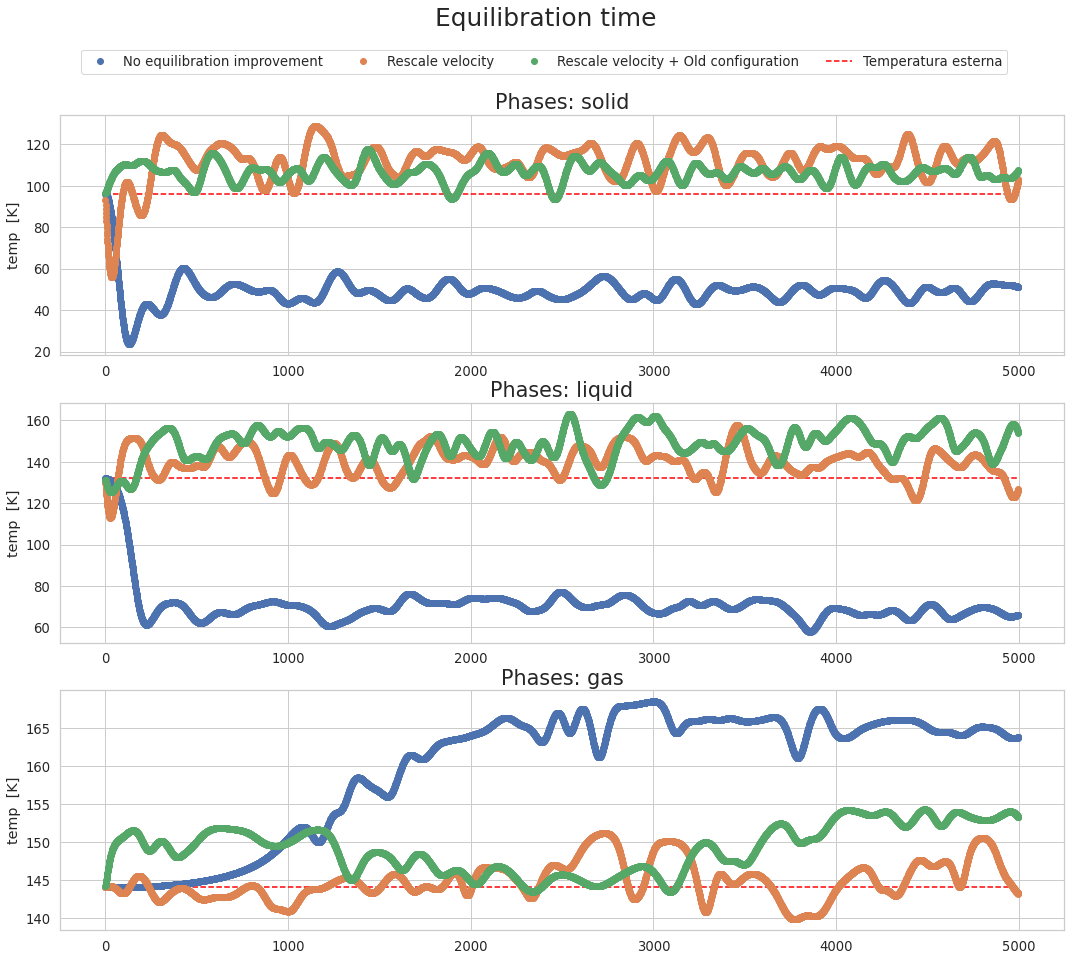

In [7]:
fig, ax = plt.subplots(3, 1, figsize=(18,15)); 
fig.suptitle('Equilibration time',fontsize='xx-large')

ax = ax.ravel()

for i in range(3):
    mask_0 = (df_0.phases == phases[i]) 
    mask_1 = (df_1.phases == phases[i]) 
    mask_2 = (df_2.phases == phases[i]) 
    ax[i].plot(df_0[mask_0].temp*temp,marker='o',linestyle='',label='No equilibration improvement')
    ax[i].plot(df_1[mask_1].temp*temp,marker='o',linestyle='', label= 'Rescale velocity')
    ax[i].plot(df_2[mask_2].temp*temp,marker='o',linestyle='', label= 'Rescale velocity + Old configuration')
    ax[i].hlines(T[i]*temp,0,len(df_1[mask_1].temp),linestyle='--',color='red',label='Temperatura esterna')
    ax[i].set_ylabel('temp'+unit[0])
    ax[i].set_title('Phases: '+phases[i], fontsize='x-large')
    
ax[0].legend(bbox_to_anchor=(0.95,1.3), ncol=4);


Osserviamo che 
* se non consideriamo alcuna modica, il sistema si porta su temperature che non sono quella da noi richiesta. 
* che il tempo di equilibrazione quando il sistema parte da una configurazione cristallina è: 

| Configurazione cristallina||
|-----------------------------|--------|
|Solido      |110|
|Liquido    |200      |
|Gas  | 40000 |

* che il tempo di equilibrazione quando il sistema parte da una configurazione precedente relativa alla stessa fase è: 

| Configurazione precedente ||
|-----------------------------|--------|
|Solido      |15|
|Liquido    |60      |
|Gas  | 250 |

> Vediamo chiramente che nel caso in cui eseguiamo un'equlibrazione in cui riscaliamo la velocità partendo da una configurazione precedente rispetto ad una configurazione cristallina, il sistema si porta alla temperatura desiderata in un tempo molto inferiore. 

## Fase solida

Analizziamo ora le proprietà della fase solida dell'Argon. Esse le otteniamo a partire da una vecchia configurazione: 


| Fase solida||
|-----------------------------|--------|
|Tempo di equilibrazione      | 15|
|Dimensione blocchi  | 100 |
|Numero di blocchi | 100 |


In [8]:
i=0 # Fase solida

a_file = open(path+'input.'+phases[i], "r")
list_of_lines = a_file.readlines()
list_of_lines[8] = "1\n"
list_of_lines[9] = "1\n"
list_of_lines[10] = str(equilibration[i])+"\n"
a_file = open(path+'input.'+phases[i], "w")
a_file.writelines(list_of_lines)
a_file.close()

a_file = open(path+"input.dat", "w")
a_file.writelines(list_of_lines)
a_file.close()

# Compilo il programma con il nuovo file di input
sb.call('./clean.sh', shell=True)
os.system('./make')
os.system('./MolDyn_NVE.exe'+' '+phases[i])

0

In [9]:
# Carico i dati da file
blk, temp_solid, std_temp_solid = np.loadtxt(path+'ave_temp.out', unpack = True ,delimiter = ",")
blk, epot_solid, std_epot_solid = np.loadtxt(path+'ave_epot.out', unpack = True ,delimiter = ",")
blk, etot_solid, std_etot_solid = np.loadtxt(path+'ave_etot.out', unpack = True ,delimiter = ",")
blk, ekin_solid, std_ekin_solid = np.loadtxt(path+'ave_ekin.out', unpack = True ,delimiter = ",")

x_solid, y_solid, z_solid = np.loadtxt(path+'config.solid.final', unpack = True)
x_solid = x_solid*length
y_solid = y_solid*length
z_solid = z_solid*length

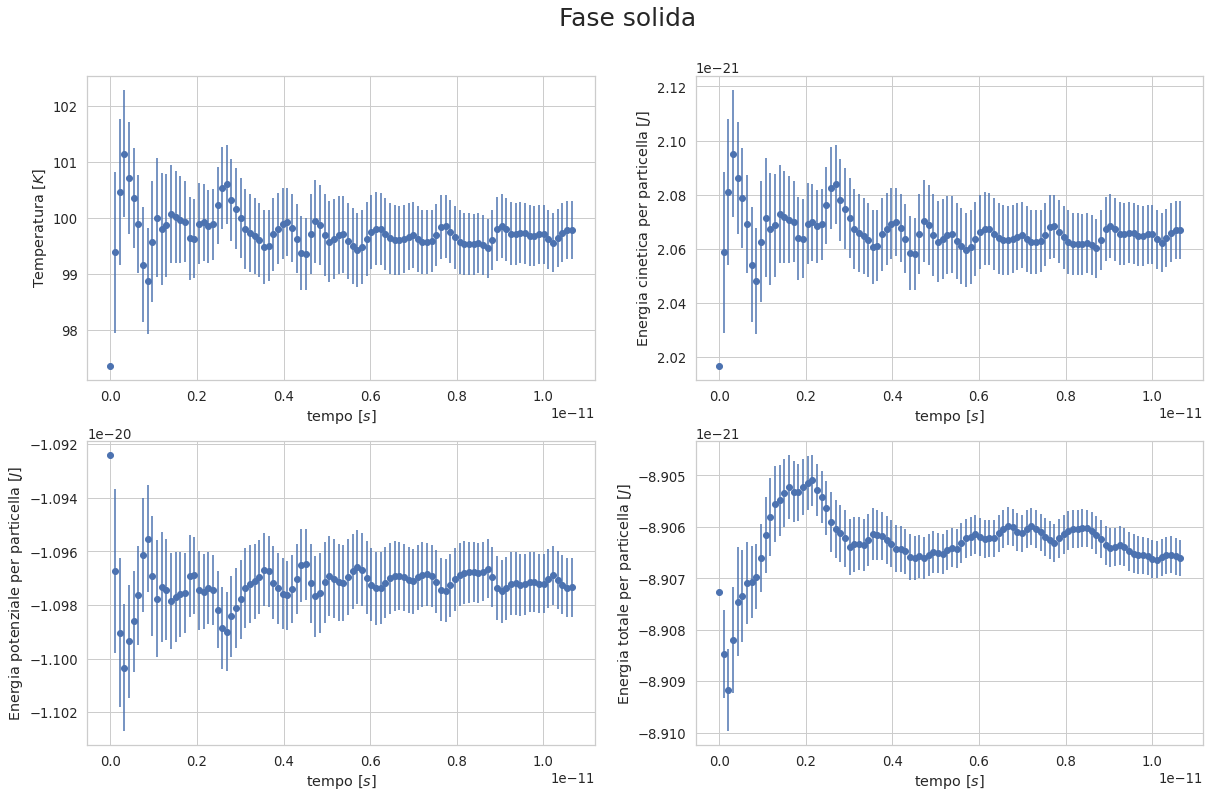

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(20,12)); 
fig.suptitle('Fase solida', fontsize='xx-large')
fig.subplots_adjust(top=0.9)

ax[0,0].errorbar(
    blk*100*time*0.0005,
    temp_solid*temp,
    yerr = std_temp_solid*temp,  
    marker='o', linestyle="", label='Metodo diretto'
);


ax[0,0].grid(True);
ax[0,0].set_ylabel(r"Temperatura $[K]$");
ax[0,0].set_xlabel(r"tempo $[s]$");

ax[0,1].errorbar(
    blk*100*time*0.0005,
    ekin_solid*energy,
    yerr = std_ekin_solid*energy,  
    marker='o', linestyle="", label='Metodo diretto'
);

ax[0,1].grid(True);
ax[0,1].set_ylabel(r"Energia cinetica per particella $[J]$");
ax[0,1].set_xlabel(r"tempo $[s]$");

ax[1,0].errorbar(
    blk*100*time*0.0005,
    epot_solid*energy,
    yerr = std_epot_solid*energy,  
    marker='o', linestyle="", label='Metodo diretto'
);

ax[1,0].grid(True);
ax[1,0].set_ylabel(r"Energia potenziale per particella $[J]$");
ax[1,0].set_xlabel(r"tempo $[s]$" );

ax[1,1].errorbar(
    blk*100*time*0.0005,
    etot_solid*energy,
    yerr = std_etot_solid*energy,  
    marker='o', linestyle="", label='Metodo diretto'
);

ax[1,1].grid(True);
ax[1,1].set_ylabel(r"Energia totale per particella $[J]$");
ax[1,1].set_xlabel(r"tempo $[s]$" );


Text(0.5, 0.92, 'Configurazione finale')

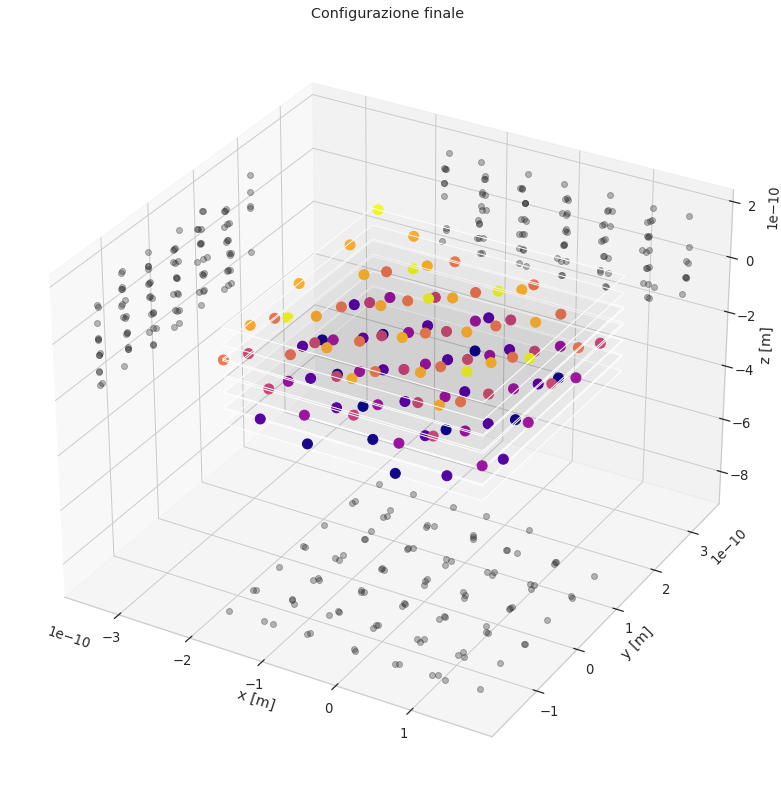

In [11]:
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(1, 2, 1, projection='3d')


x = np.linspace(np.min(x_solid), np.max(x_solid),2,endpoint=True)
y = np.linspace(np.min(y_solid), np.max(y_solid),2,endpoint=True)

xx, yy = np.meshgrid(x, y)

for i in np.arange(0,np.size(z_solid),10):
    z = 0*xx+z_solid[i]
    ax.plot_surface(xx, yy, z, alpha=0.01, color='black')
    
ax.plot(x_solid, y_solid, 'ko', zdir='z', zs=-2.5*length, alpha=0.3)
ax.plot(y_solid, z_solid, 'ko', zdir='x', zs=-1*length, alpha=0.3)
ax.plot(x_solid, z_solid, 'ko', zdir='y', zs=1*length, alpha=0.3)

ax.scatter(x_solid, y_solid, z_solid, s=10**2, c=z_solid, cmap='plasma', marker='o', alpha=1);
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]');
ax.set_title('Configurazione finale')

> Osserviamo che la disposizione delle particelle presenta una struttura cristallina e questo certifica che il sistema si trova nella fase solida.

## Fase liquida

Analizziamo ora le proprietà della fase liquida dell'Argon. Esse le otteniamo a partire da una vecchia configurazione: 


| Fase liquida||
|-----------------------------|--------|
|Tempo di equilibrazione      | 60|
|Dimensione blocchi  | 100 |
|Numero di blocchi | 100 |


In [12]:
i=1 # Fase liquida

a_file = open(path+'input.'+phases[i], "r")
list_of_lines = a_file.readlines()
list_of_lines[8] = "1\n"
list_of_lines[9] = "1\n"
list_of_lines[10] = str(equilibration[i])+"\n"
a_file = open(path+'input.'+phases[i], "w")
a_file.writelines(list_of_lines)
a_file.close()

a_file = open(path+"input.dat", "w")
a_file.writelines(list_of_lines)
a_file.close()

# Compilo il programma con il nuovo file di input
sb.call('./clean.sh', shell=True)
os.system('./make')
os.system('./MolDyn_NVE.exe'+' '+phases[i])

0

In [13]:
# Carico i dati da file
blk, temp_liquid, std_temp_liquid = np.loadtxt(path+'ave_temp.out', unpack = True ,delimiter = ",")
blk, epot_liquid, std_epot_liquid = np.loadtxt(path+'ave_epot.out', unpack = True ,delimiter = ",")
blk, etot_liquid, std_etot_liquid = np.loadtxt(path+'ave_etot.out', unpack = True ,delimiter = ",")
blk, ekin_liquid, std_ekin_liquid = np.loadtxt(path+'ave_ekin.out', unpack = True ,delimiter = ",")

x_liquid, y_liquid, z_liquid = np.loadtxt(path+'config.liquid.final', unpack = True)
x_liquid = x_liquid*length
y_liquid = y_liquid*length
z_liquid = z_liquid*length

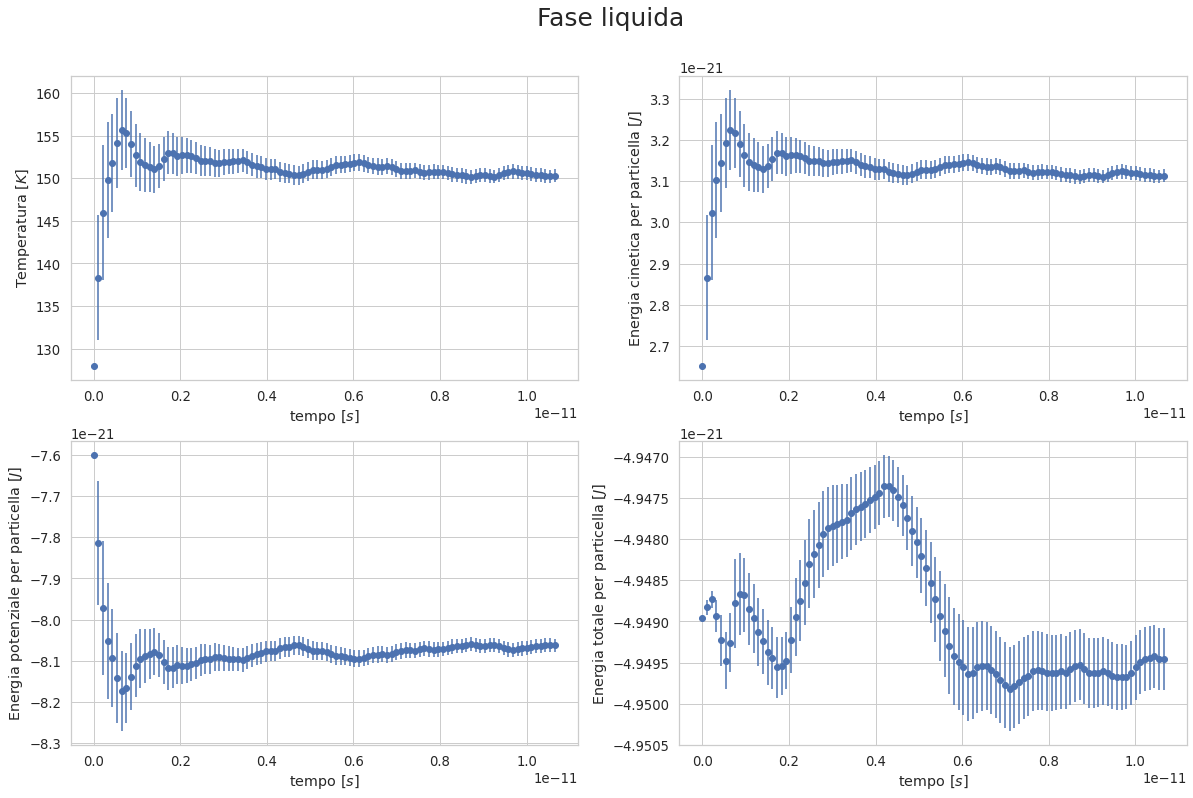

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(20,12)); 
fig.suptitle('Fase liquida', fontsize='xx-large')
fig.subplots_adjust(top=0.9)

ax[0,0].errorbar(
    blk*100*time*0.0005,
    temp_liquid*temp,
    yerr = std_temp_liquid*temp,  
    marker='o', linestyle="", label='Metodo diretto'
);


ax[0,0].grid(True);
ax[0,0].set_ylabel(r"Temperatura $[K]$");
ax[0,0].set_xlabel(r"tempo $[s]$");

ax[0,1].errorbar(
    blk*100*time*0.0005,
    ekin_liquid*energy,
    yerr = std_ekin_liquid*energy,  
    marker='o', linestyle="", label='Metodo diretto'
);

ax[0,1].grid(True);
ax[0,1].set_ylabel(r"Energia cinetica per particella $[J]$");
ax[0,1].set_xlabel(r"tempo $[s]$");

ax[1,0].errorbar(
    blk*100*time*0.0005,
    epot_liquid*energy,
    yerr = std_epot_liquid*energy,  
    marker='o', linestyle="", label='Metodo diretto'
);

ax[1,0].grid(True);
ax[1,0].set_ylabel(r"Energia potenziale per particella $[J]$");
ax[1,0].set_xlabel(r"tempo $[s]$" );

ax[1,1].errorbar(
    blk*100*time*0.0005,
    etot_liquid*energy,
    yerr = std_etot_liquid*energy,  
    marker='o', linestyle="", label='Metodo diretto'
);

ax[1,1].grid(True);
ax[1,1].set_ylabel(r"Energia totale per particella $[J]$");
ax[1,1].set_xlabel(r"tempo $[s]$" );


Text(0.5, 0.92, 'Configurazione finale')

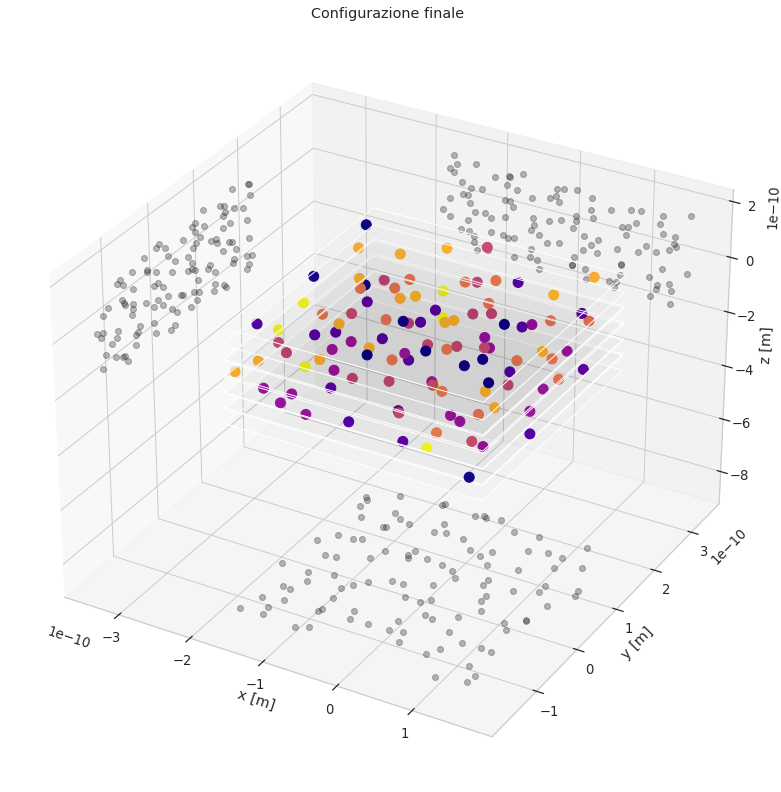

In [15]:
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(1, 2, 1, projection='3d')


x = np.linspace(np.min(x_liquid), np.max(x_liquid),2,endpoint=True)
y = np.linspace(np.min(y_liquid), np.max(y_liquid),2,endpoint=True)

xx, yy = np.meshgrid(x, y)

for i in np.arange(0,np.size(z_liquid),10):
    z = 0*xx+z_solid[i]
    ax.plot_surface(xx, yy, z, alpha=0.01, color='black')
    
ax.plot(x_liquid, y_liquid, 'ko', zdir='z', zs=-2.5*length, alpha=0.3)
ax.plot(y_liquid, z_liquid, 'ko', zdir='x', zs=-1*length, alpha=0.3)
ax.plot(x_liquid, z_liquid, 'ko', zdir='y', zs=1*length, alpha=0.3)

ax.scatter(x_liquid, y_liquid, z_liquid, s=10**2, c=z_solid, cmap='plasma', marker='o', alpha=1);
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]');
ax.set_title('Configurazione finale')


> Osserviamo che il sistema si trova in una fase disordinata che può essere assimilabile alla fase liquida.

## Fase gassosa

Analizziamo ora le proprietà della fase gassosa dell'Argon. Esse le otteniamo a partire da una vecchia configurazione: 


| Fase gassosa||
|-----------------------------|--------|
|Tempo di equilibrazione      | 250|
|Dimensione blocchi  | 100 |
|Numero di blocchi | 100 |



In [16]:
i=2 # Fase gassosa

a_file = open(path+'input.'+phases[i], "r")
list_of_lines = a_file.readlines()
list_of_lines[8] = "1\n"
list_of_lines[9] = "1\n"
list_of_lines[10] = str(equilibration[i])+"\n"
a_file = open(path+'input.'+phases[i], "w")
a_file.writelines(list_of_lines)
a_file.close()

a_file = open(path+"input.dat", "w")
a_file.writelines(list_of_lines)
a_file.close()

# Compilo il programma con il nuovo file di input
sb.call('./clean.sh', shell=True)
os.system('./make')
os.system('./MolDyn_NVE.exe'+' '+phases[i])

0

In [17]:
# Carico i dati da file
blk, T, std_T = np.loadtxt(path+'ave_temp.out', unpack = True ,delimiter = ",")
blk, epot, std_epot = np.loadtxt(path+'ave_epot.out', unpack = True ,delimiter = ",")
blk, etot, std_etot = np.loadtxt(path+'ave_etot.out', unpack = True ,delimiter = ",")
blk, ekin, std_ekin = np.loadtxt(path+'ave_ekin.out', unpack = True ,delimiter = ",")

xdata, ydata, zdata = np.loadtxt(path+'config.gas.final', unpack = True)
xdata = xdata*length
ydata = ydata*length
zdata = zdata*length

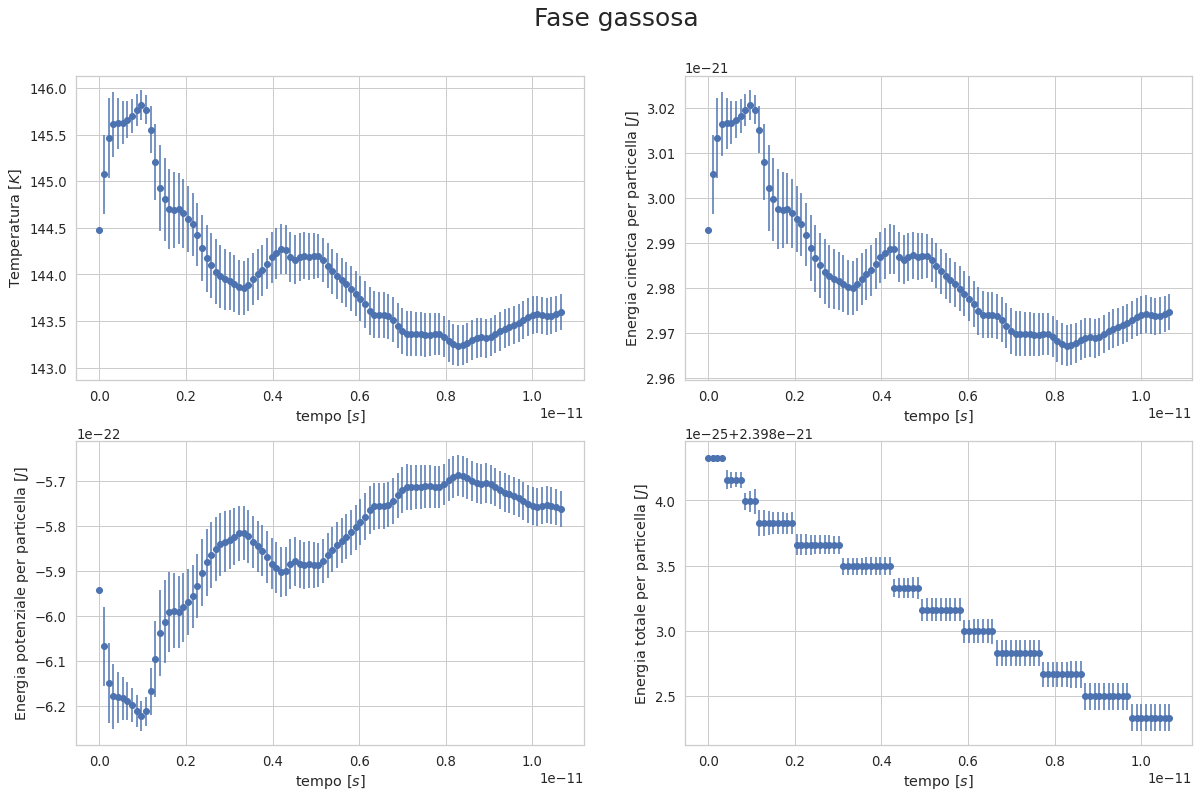

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(20,12)); 
fig.suptitle('Fase gassosa', fontsize='xx-large')
fig.subplots_adjust(top=0.9)

ax[0,0].errorbar(
    blk*100*time*0.0005,
    T*temp,
    yerr = std_T*temp,  
    marker='o', linestyle="", label='Metodo diretto'
);


ax[0,0].grid(True);
ax[0,0].set_ylabel(r"Temperatura $[K]$");
ax[0,0].set_xlabel(r"tempo $[s]$");

ax[0,1].errorbar(
    blk*100*time*0.0005,
    ekin*energy,
    yerr = std_ekin*energy,  
    marker='o', linestyle="", label='Metodo diretto'
);

ax[0,1].grid(True);
ax[0,1].set_ylabel(r"Energia cinetica per particella $[J]$");
ax[0,1].set_xlabel(r"tempo $[s]$");

ax[1,0].errorbar(
    blk*100*time*0.0005,
    epot*energy,
    yerr = std_epot*energy,  
    marker='o', linestyle="", label='Metodo diretto'
);

ax[1,0].grid(True);
ax[1,0].set_ylabel(r"Energia potenziale per particella $[J]$");
ax[1,0].set_xlabel(r"tempo $[s]$" );

ax[1,1].errorbar(
    blk*100*time*0.0005,
    etot*energy,
    yerr = std_etot*energy,  
    marker='o', linestyle="", label='Metodo diretto'
);

ax[1,1].grid(True);
ax[1,1].set_ylabel(r"Energia totale per particella $[J]$");
ax[1,1].set_xlabel(r"tempo $[s]$" );


Text(0.5, 0.92, 'Configurazione finale')

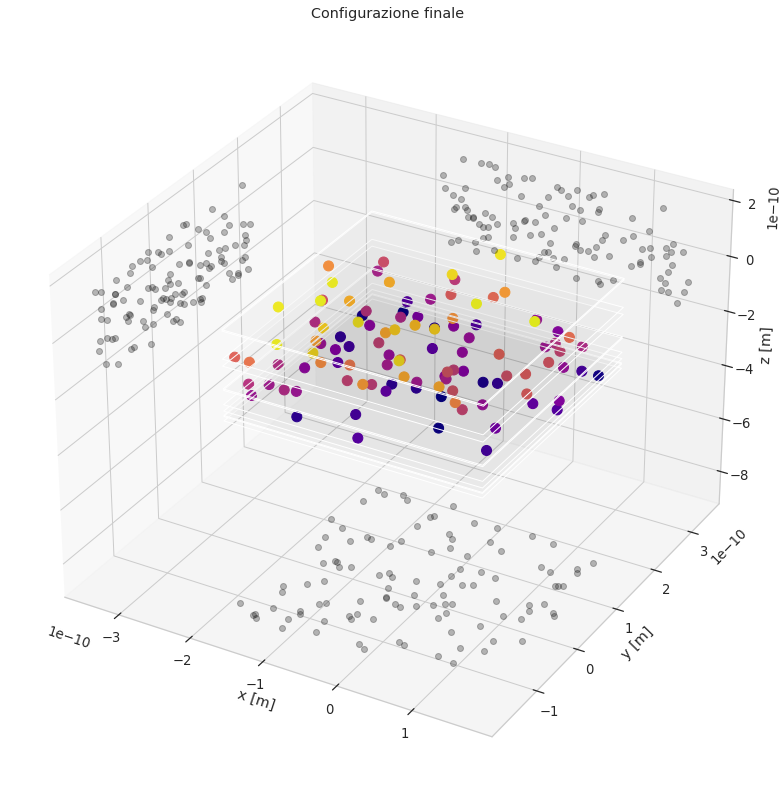

In [19]:
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(1, 2, 1, projection='3d')


x = np.linspace(np.min(xdata), np.max(xdata),2,endpoint=True)
y = np.linspace(np.min(ydata), np.max(ydata), 2,endpoint=True)

xx, yy = np.meshgrid(x, y)
for i in np.arange(0,np.size(zdata),10):
    z = 0*xx+zdata[i]
    ax.plot_surface(xx, yy, z, alpha=0.01,color='black')

ax.scatter(xdata, ydata, zdata, s=10**2, c=zdata, cmap='plasma', marker='o', alpha=1);

ax.plot(xdata, ydata, 'ko', zdir='z', zs=-2.5*length, alpha=0.3)
ax.plot(ydata, zdata, 'ko', zdir='x', zs=-1*length, alpha=0.3)
ax.plot(xdata, zdata, 'ko', zdir='y', zs=1*length, alpha=0.3)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]');
ax.set_title('Configurazione finale')

>Anche in questo caso abbiamo una disposizione molto disordinata che può descrivere lo stato gassoso dell'Argon.